In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import LogNorm

import matplotlib as mpl
font = {        'size'   : 15}
mpl.rc('font', **font)

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Road Network Data
Insert road network / distance matrix things. Assume will output a distance tensor $D$ of size $T \times N \times N$

In [2]:
# D=500*np.random.rand(11,19,19) # just a place-holder
df_distances = pd.read_excel('distances_new.xlsx')
df_distances.head()
D = df_distances.to_numpy()[:,1:]
D = np.array([D for i in range(11)])
for t in range(11):
    np.fill_diagonal(D[t,:,:],0)
# print(D.shape)
# print(D)

# Social Network Data

In [3]:
cities_final = pd.read_csv('../data/cities_final.csv')
cities_final.head()

,CityId,CityName,Latitude,Longitude,PopLog
0,379,Budapest,47.498382,19.040471,6.240560
1,380,Debrecen,47.531399,21.625978,5.317215
2,381,Miskolc,48.103150,20.790198,5.222256
3,382,Szeged,46.254631,20.148602,5.230582
4,383,Pecs,46.076322,18.228075,5.195349


In [4]:
# Getting the top 20 cities
iwiw_codes = [379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 396, 1842, 2103]
iwiw_code_dict= {379: 'Budapest', 380: 'Debrecen', 381: 'Miskolc', 382: 'Szeged', 383: 'Pecs', 384: 'Gyor', 385: 'Nyiregyhaza', 386: 'Kecskemet',
 387: 'Szekesfehervar', 388: 'Szombathely', 389: 'Szolnok', 390: 'Tatabanya', 391: 'Kaposvar', 392: 'Bekescsaba', 393: 'Zalaegerszeg',
 394: 'Veszprem', 396: 'Eger', 1842: 'Szekszard', 2103: 'Salgotarjan'}

In [5]:
invitations_iwiw = pd.read_csv('../data/invitation_counts.csv.gz')
invitations_iwiw.head()

,RegYear,CityId,InvitorCityId,w
0,2002,379,379,3809
1,2002,379,380,6
2,2002,379,381,7
3,2002,379,382,8
4,2002,379,383,12


In [6]:
mask1 = invitations_iwiw["CityId"].map(lambda i: i in iwiw_codes)
mask2 = invitations_iwiw["InvitorCityId"].map(lambda i: i in iwiw_codes)
mask3 = invitations_iwiw["InvitorCityId"]!=invitations_iwiw["CityId"]

In [7]:
# Edgelist with only the top 19
reduced_df = invitations_iwiw[mask1&mask2]
reduced_df.head()
# print(len(reduced_df['InvitorCityId'].unique()))

,RegYear,CityId,InvitorCityId,w
0,2002,379,379,3809
1,2002,379,380,6
2,2002,379,381,7
3,2002,379,382,8
4,2002,379,383,12


In [8]:
Years = list(reduced_df['RegYear'].unique())
Graph_list = [nx.to_numpy_array(nx.from_pandas_edgelist(reduced_df[reduced_df['RegYear']==year],
                                                        source='InvitorCityId',target='CityId',edge_attr='w',
                                                        create_using=nx.DiGraph),weight='w',dtype=int)
             for year in Years]

# asymmetric, weighted tensor of size T x N x N
W = np.array(Graph_list)

# asymmetric, normalised tensor
W_norm = np.zeros_like(W,dtype='float64')
for t in range(W.shape[0]):
    W_norm[t,:,:] = W[t,:,:]
#     np.fill_diagonal(W_norm[t,:,:],0) # removing all self-loops
    W_norm[t,:,:] /= W_norm[t,:,:].sum()

In [9]:
# symmetrised, weighted social connection tensor S
S = np.cumsum(W + np.transpose(W,axes=[0,2,1]),axis=0)
# correcting the self loops since double counted
for i in range(S.shape[2]):
    S[:,i,i] = S[:,i,i]/2

# Null Models

In [16]:
# Null Model 1 - Random Graph
S_ti = np.sum(S,axis=2)
S_null_random = np.zeros_like(S,dtype='float64')
for t in range(S.shape[0]):
    S_null_random[t,:,:] = np.outer(S_ti[t,:],S_ti[t,:]) / np.sum(S[t,:,:])
    

# Null Model 2 - Gravity Model
    # requires the distance tensor too!
S_null_gravity = np.zeros_like(S)
    #exponents:
alpha = 1
beta = 1
gamma = 2
n=users_per_city(W) # natively two cities have 0 users to begin with
for t in range(S.shape[0]):
    S_null_gravity[t,:,:] = np.outer(n[t,:]**alpha,n[t,:]**beta)/D[t,:,:]**gamma
    

# Null Model 3 - Radiation Model
S_null_radiation = np.zeros_like(S)
m = np.zeros_like(S)
for t in range(S.shape[0]):
    for i in range(S.shape[1]):
        for j in range(S.shape[2]):
            for k in range(S.shape[2]):
                if D[t,i,k] <= D[t,i,j]:
                    m[t,i,j] += n[t,k]
    for i in range(S.shape[1]):
        for j in range(S.shape[2]):
            S_null_radiation[t,i,j] = S_ti[t,i]*n[t,i]*n[t,j]/((n[t,i]+n[t,j]+m[t,i,j])*(n[t,i]+m[t,i,j]))

/home/jbara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


In [17]:
# symmetrised, social connection tensor S_norm normalised to the null model
S_norm = S/S_null_random
for t in range(11):
    np.fill_diagonal(S_norm[t,:,:],0)

# Visualisations of social network

ValueError: Invalid vmin or vmax

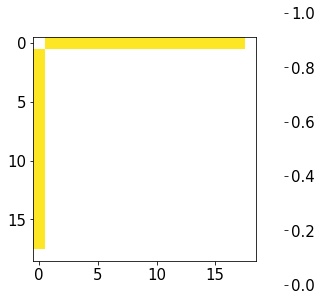

In [31]:
# Visualising S_norm for each year
for t in range(S.shape[0]):
    plt.figure(figsize=(5,5))
    im=plt.imshow(S_norm[t,:,:],
               norm=LogNorm(vmin=S_norm[S_norm>0].min(),vmax=S_norm.max()))
    plt.colorbar(im)
    plt.title(Years[t])

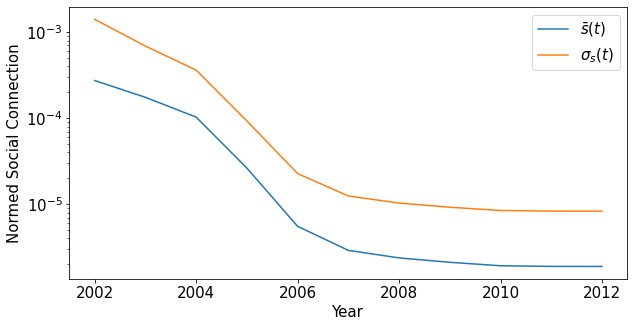

In [62]:
fig=plt.figure(figsize=(10,5))

plt.plot(Years,[S_norm[t,:,:].mean() for t in range(S.shape[0])],label=r'$\bar{s} (t)$')
# plt.plot(Years,[W_norm[t,:,:].mean() for t in range(S.shape[0])],label=r'$\bar{w} (t)$')

plt.plot(Years,[S_norm[t,:,:].std() for t in range(S.shape[0])],label=r'$\sigma_s (t)$')
# plt.plot(Years,[W_norm[t,:,:].std() for t in range(S.shape[0])],label=r'$\sigma_w (t)$')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Normed Social Connection")
plt.yscale('log')

# Quantities of potential use
Given the social connection tensor $S$ (or $W$) and distance tensor $D$. Note tensor here just means stack the relevant matrices at different timestamps on top of one another, e.g. $S$-tensor = $[S(t=0),S(t=1),...,S(t=T)]$

In [12]:
def lag_corr(A,B,t,tau):
    # A and B must be tensors with time on axis 0, the rest of the dimensions must be the same
    if t >= A.shape[0] or t+tau>=B.shape[0]:
        return 0
    else:
        return np.corrcoef(A[t,:,:].flatten(),B[t+tau,:,:].flatten())[0,1]

def users_per_city(W):
    n = np.zeros([W.shape[0],W.shape[1]],dtype='int')
    for t in range(W.shape[0]):
        n[t,:] = np.sum(W[0,:,:],axis=1) + np.sum(W[0:t+1,:,:],axis=(0,2))
    n[n==0]+=1 # artificially ensuring no cities have 0 users!
    return n    
    
def per_user_probability_t(D,S,n,d_min,d_max,t):
    # outputs the per-user probability at time t for conncections between distance [d_min,d_max)
        # D - distance tensor T x N x N
        # S - symmetrised connection tensor T x N x N
        # n - number of users matrix T x N
        # [d_min,d_max) interval for distances
        # t - time index
    mask = (D[t,:,:]>=d_min)&(D[t,:,:]<d_max)
    s = np.triu(S[t,:,:]*mask).sum()
    s_p = (np.outer(n[t,:],n[t,:])*mask).sum()
    return s/s_p

def per_user_probability(D,S,n,d_min,d_max,bar=False):
    # outputs the per-user probability at time t for conncections between distance [d_min,d_max)
        # D - distance tensor T x N x N
        # S - symmetrised connection tensor T x N x N
        # n - number of users matrix T x N
        # [d_min,d_max) interval for distances
    if bar:
        s = np.zeros(S.shape[0])
        s_p = np.zeros(S.shape[0])
        for t in range(S.shape[0]):
            mask = (D[t,:,:]>=d_min)&(D[t,:,:]<d_max)
            s[t] = np.triu(S[t,:,:]*mask).sum()
            s_p[t] = (np.outer(n[t,:],n[t,:])*mask).sum()
        return s.sum()/s_p.sum()
    else:
        return np.mean([per_user_probability_t(D,S,n,d_min,d_max,t) for t in range(D.shape[0])])

In [13]:
# Wrappers while we don't yet have D
def lag_corr_matrix(A,B):
    rho = np.zeros([A.shape[0],B.shape[0]])
    for t in range(A.shape[0]):
        for tau in range(B.shape[0]):
            rho[t,tau] = lag_corr(A,B,t,tau)
    return rho

def maximal_lag_corr(A,B):
    return np.min(lag_corr_matrix(A,B),axis=1)

def char_timescales(A,B):
    return np.argmin(lag_corr_matrix(A,B),axis=1)

# Potential analysis
$D$ can be the tensor of either spatial distances or travel times

$P(d)$ needs to be properly normalised to get a distribution in distances hence have a $\tilde{P}(d) \propto P(d)$ such that $\int \tilde{P}(x) dx= 1$.

In [14]:
# Correctly normalised (i.e. sum to 1) distance distribution P_tilde(d)
def distance_distribution(D,S,n,bins=50,bar=False,t=None):
    # If t = None, will use P(d), otherwise if t is specified will use P(d,t)
    
    # bins can be either int or array
    if type(bins)==int:
        bins = np.linspace(D.min(),D.max()+1,num=bins)
    if t==None:
        P_tilde = [per_user_probability(D,S,n,bins[i],bins[i+1],bar=bar) for i in range(len(bins)-1)]
    else:
        P_tilde = [per_user_probability_t(D,S,n,bins[i],bins[i+1],t) for i in range(len(bins)-1)]
    return P_tilde/np.sum(P_tilde)#,bins



[     0.  50000. 100000. 150000. 200000. 250000. 300000. 350000. 400000.
 450000. 500000.]


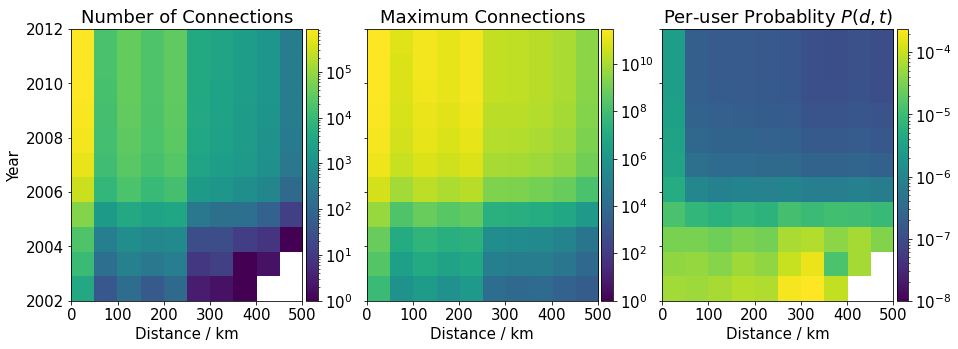

In [51]:
T = np.arange(2002,2013)
# d = np.linspace(D.min(),D.max()+1,num=bins)
d = np.arange(0,5.5e5,5e4)
# bins = 10
s = np.zeros([11,len(d)-1])
s_p = np.zeros([11,len(d)-1])

for t,tp in enumerate(T):
    for d_ind,d_val in enumerate(d[:-1]):
        mask = (D[t,:,:]>=d[d_ind])&(D[t,:,:]<d[d_ind+1])
        s[t,d_ind] = np.triu(S[t,:,:]*mask).sum()
        s_p[t,d_ind] = (np.outer(n[t,:],n[t,:])*mask).sum()


fig,axs = plt.subplots(figsize=(15,5),ncols=3,sharey=True)
szzz = [s,s_p,s/s_p]
labels = ['Number of Connections','Maximum Connections','Per-user Probablity $P(d,t)$']

print(d)
for i in range(2):
    im = axs[i].imshow(szzz[i],
                       extent=[min(d)/1000,max(d)/1000,2002,2012],
                       aspect='auto',origin='lower',
                       norm=LogNorm(vmin=1,
                                    vmax=np.max(szzz[i])))
#     axs[i].set_colorbar(im)
    axs[i].set_xlabel('Distance / km')
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    axs[i].set_title(labels[i])
for i in range(2,3):
    im = axs[i].imshow(szzz[i],
                       extent=[min(d)/1000,max(d)/1000,2002,2012],
                       aspect='auto',origin='lower',
                       norm=LogNorm(vmin=1e-8,
                                    vmax=np.max(szzz[i])))
#     axs[i].set_colorbar(im)
    axs[i].set_xlabel('Distance / km')
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    axs[i].set_title(labels[i])
axs[0].set_ylabel('Year')

fig.savefig("Per User Probability.png",bbox_inches='tight')